# Convolutional Neural Network (CNN)

# 1. Schritt: Audio-Dateien laden und in MFCCs umwandeln

In [1]:
import sys

import numpy as np
import os
sys.path.append(os.path.abspath(".."))

from feature_extraction import get_mfccs_from_coswara_audio_files
from feature_extraction import get_mfccs_from_virufy_audio_files
from feature_extraction import get_mfccs_from_coughvid_audio_files
from feature_extraction import get_valid_coswara_folder_names

labels_dict = {0: "neg", 1: "pos"}

labels, mfccs = [], []

p_folder_names, n_folder_names = get_valid_coswara_folder_names()

# Umwandlung der Coswara-Audio-Dateien in MFCCss
p_coswara_mfccs, p_coswara_labels = get_mfccs_from_coswara_audio_files(
    p_folder_names, is_positive=True
)

n_coswara_mfccs, n_coswara_labels = get_mfccs_from_coswara_audio_files(
    n_folder_names, is_positive=False
)

print("Positive Coswara samples: ", len(p_coswara_mfccs))
print("Negative Coswara samples: ", len(n_coswara_mfccs))

# Umwandlung der Virufy-Audio-Dateien in MFCCs
p_virufy_mfccs, p_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=True
)
n_virufy_mfccs, n_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=False
)

print("Positive Virufy samples: ", len(p_virufy_mfccs))
print("Negative Virufy samples: ", len(n_virufy_mfccs))

n_coughvid_folder_names = "neg"
p_coughvid_folder_names = "pos"

# Umwandlung der Coughvid-Audio-Dateien in MFCCs
p_coughvid_mfccs, p_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    n_coughvid_folder_names,
    is_positive=True
)
n_coughvid_mfccs, n_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    p_coughvid_folder_names,
    is_positive=False
)

print("Positive Coughvid samples: ", len(p_coughvid_mfccs))
print("Negative Coughvid samples: ", len(n_coughvid_mfccs))

mfcc = np.concatenate(
    (p_coswara_mfccs, n_coswara_mfccs, p_virufy_mfccs, n_virufy_mfccs,
     p_coughvid_mfccs, n_coughvid_mfccs)
)

labels = np.concatenate(
    (p_coswara_labels, n_coswara_labels, p_virufy_labels, n_virufy_labels,
     p_coughvid_labels, n_coughvid_labels)
)

mfcc = np.array(mfcc, dtype=np.float32)

labels = np.array(labels, dtype=np.int32)

print(len(mfcc), len(labels))


2025-03-04 19:02:39.654414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Positive Coswara samples:  1356
Negative Coswara samples:  3098
Positive Virufy samples:  7
Negative Virufy samples:  9
Positive Coughvid samples:  9983
Negative Coughvid samples:  924
15377 15377


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=2)

# Train-Test-Split durchführen
# Daten in 70% Training und 30% für die Validierung und Test aufteilen
mfcc_train, mfcc_temp, labels_train, labels_temp = train_test_split(
    mfcc, labels, test_size=0.3, random_state=42
)

# 30% werden nochmal in 15% für die Validierung und 15% für den Test aufgeteilt
mfcc_val, mfcc_test, labels_val, labels_test = train_test_split(
    mfcc_temp, labels_temp, test_size=0.5, random_state=42
)

print(
    f"""mfcc_train.shape: {mfcc_train.shape},
    labels_train.shape: {labels_train.shape}"""
)
print(
    f"""mfcc_test.shape: {mfcc_test.shape},
    labels_test.shape: {labels_test.shape}"""
)


mfcc_train.shape: (10763, 64, 1),
    labels_train.shape: (10763, 2)
mfcc_test.shape: (2307, 64, 1),
    labels_test.shape: (2307, 2)


# 3. Schritt: CNN-Modelle erstellen

In [3]:
# Konfiguration des Trainingsprozesses
BATCH_SIZE = 32
EPOCHS = 50
ACTIVATION_1 = "relu"
ACTIVATION_2 = "softmax"
METRIC = "accuracy"
LOSS = "binary_crossentropy"
OPTIMIZER = "adam"


## 3.1. Experiment: Geeignetes CNN-Modell finden

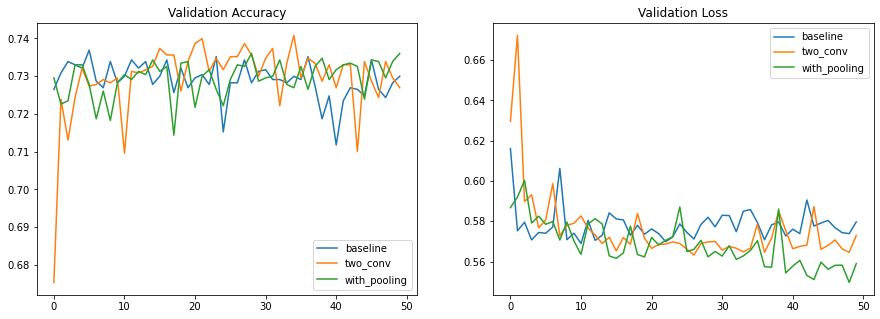


baseline:
Final val_accuracy: 0.7300
Final val_loss: 0.5797

two_conv:
Final val_accuracy: 0.7269
Final val_loss: 0.5729

with_pooling:
Final val_accuracy: 0.7360
Final val_loss: 0.5590


In [4]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def experiment_architectures(x_train, y_train, x_val, y_val):
    """
    Experimentieren mit verschiedenen Architekturen

    :param x_train: Trainingsdaten
    :param y_train: Trainingslabels
    :param x_val: Validierungsdaten
    :param y_val: Validierungslabels
    """
    results = {}
    input_shape = mfcc[0].shape

    # Test 1: Basismodell
    model1 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        MaxPooling1D(2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model1.compile(
        optimizer=OPTIMIZER,
        loss=LOSS,
        metrics=[METRIC]
    )
    history1 = model1.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    results['baseline'] = history1.history

    # Test 2: Zwei Convolutional Layers
    model2 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        MaxPooling1D(2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model2.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
    history2 = model2.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0)
    results['two_conv'] = history2.history

    # Test 3: Dropout Layer
    model3 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model3.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
    history3 = model3.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0)
    results['with_pooling'] = history3.history

    return results

def analyze_results(results):
    """
    Analyse der Ergebnisse

    :param results: Ergebnisse der Experimente
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for name, history in results.items():
        plt.plot(history['val_accuracy'], label=f'{name}')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, history in results.items():
        plt.plot(history['val_loss'], label=f'{name}')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

    for name, history in results.items():
        print(f"\n{name}:")
        print(f"Final val_accuracy: {history['val_accuracy'][-1]:.4f}")
        print(f"Final val_loss: {history['val_loss'][-1]:.4f}")

results = experiment_architectures(mfcc_train, labels_train, mfcc_test, labels_test)
analyze_results(results)



# 3.1. Schritt: CNN mit kausaler Faltung

In [5]:
def build_cnn(*, include_future: bool) -> Sequential:
    """Erstellt ein CNN-Modell, das auf den MFCCs trainiert wird.

    :param include_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: CNN-Modell (TensorFlow Sequential Model)
    """
    # Eingabeform: (128, 128, 1)
    input_shape = mfcc[0].shape

    padding_value = "valid"
    if not include_future:
        padding_value = "causal"

    model = Sequential([
        Input(shape=input_shape),

        # Weitere Testmodelle
        # Conv1D(32, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(32, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # MaxPooling1D(2),
        # Dropout(0.2),

        # Conv1D(64, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(64, 3, activation=ACTIVATION_2, padding=padding_value),
        # MaxPooling1D(2),
        # Dropout(0.2),

        # Conv1D(128, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(128, 3, activation=ACTIVATION_2, padding=padding_value),
        # GlobalAveragePooling1D(),

        # # Dense Layers
        # Dense(256, activation=ACTIVATION_2),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(128, activation=ACTIVATION_2),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(64, activation=ACTIVATION_2),
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1, padding=padding_value),
        MaxPooling1D(2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])

    model.summary()
    return model


In [6]:
# Modell erstellen, was die Zukunft nicht berücksichtigt
causal_model = build_cnn(include_future=False)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        multiple                  0         
                                                                 
 conv1d_3 (Conv1D)           (None, 64, 32)            128       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 2,178
Trainable params: 2,178
Non-trainable params: 0
____________________________________________________

# 3.2. Schritt: CNN mit normaler Faltung

In [7]:
# Modell erstellen, was die Zukunft berücksichtigt
non_causal_model = build_cnn(include_future=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        multiple                  0         
                                                                 
 conv1d_4 (Conv1D)           (None, 62, 32)            128       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 31, 32)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 992)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1986      
                                                                 
Total params: 2,114
Trainable params: 2,114
Non-trainable params: 0
____________________________________________________

# 4. Modell kompilieren

In [8]:
# Modelle werden für das Training vorbereitet
# Optimierungsalgorithmus: Adam (Optimierungsalgorithmus) (Wie werden die
# Gewichte angepasst)
# Verlustfunktion: Categorical Crossentropy (Wie werden die Fehler berechnet)
# Metrik: Genauigkeit (Welche Metrik wird zur Bewertung des Modells verwendet)
causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
non_causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])


#  5 Schritt: W&B Project initialisieren und Modell trainieren

In [9]:
def train_and_wandbLog(
    model, mfcc_train, labels_train, mfcc_test, labels_test, *, with_future: bool
):
    """Trainiert das Modell und loggt die Metriken in Weights & Biases.

    :param model: Modell, das trainiert werden soll
    :param mfcc_train: Trainingsdaten (MFCCs)
    :param labels_train: Trainingsdaten (Labels)
    :param mfcc_test: Testdaten (MFCCs)
    :param labels_test: Testdaten (Labels)
    :param with_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: History-Objekt des Trainingsprozesses
    """
    import wandb

    wandb.init(
        project="cnn_covid_audio_classification",
        config={
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "architecture": "CNN",
            "dataset": "coswara + virufy + coughvid",
            "activation_1": ACTIVATION_1,
            "activation_2": ACTIVATION_2,
            "metric": METRIC,
            "loss": LOSS,
            "optimizer": OPTIMIZER,
        },
    )

    # WandB Run Name setzen
    FUTURE = "FUTURE" if with_future else "NO_FUTURE"
    wandb.run.name = f"{FUTURE}_batch_size_{BATCH_SIZE}_epochs_{EPOCHS}_activation_1_{ACTIVATION_1}_activation_2_{ACTIVATION_2}_metric_{METRIC}_loss_{LOSS}_optimizer_{OPTIMIZER}"

    history = model.fit(
        mfcc_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mfcc_test, labels_test),
        callbacks=[
            wandb.keras.WandbMetricsLogger(log_freq=5),
            wandb.keras.WandbModelCheckpoint("models"),
        ],
    )

    history = model.fit(
        mfcc_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mfcc_test, labels_test),
    )

    # wandb.finish()
    return history


In [10]:
# Training des Modells
history = train_and_wandbLog(
    non_causal_model, mfcc_train, labels_train, mfcc_test, labels_test, with_future=True
)
test_loss, test_acc = non_causal_model.evaluate(mfcc_test, labels_test, verbose=2)

print("\nTest accuracy:", test_acc)
test_loss, test_acc = non_causal_model.evaluate(mfcc_test, labels_test, verbose=2)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: paula-schwalm (paula-schwalm-technische-hochschule-mittelhessen-thm). Use `wandb login --relogin` to force relogin


Epoch 1/50
327/337 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.7180

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


337/337 [==============================] - 2s 5ms/step - loss: 0.6413 - accuracy: 0.7189 - val_loss: 0.6513 - val_accuracy: 0.7226
Epoch 2/50
329/337 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.7386

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5644 - accuracy: 0.7398 - val_loss: 0.5795 - val_accuracy: 0.7287
Epoch 3/50
336/337 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.7471

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5585 - accuracy: 0.7473 - val_loss: 0.6273 - val_accuracy: 0.7230
Epoch 4/50
329/337 [============================>.] - ETA: 0s - loss: 0.5582 - accuracy: 0.7443

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5574 - accuracy: 0.7450 - val_loss: 0.5710 - val_accuracy: 0.7365
Epoch 5/50
332/337 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.7511

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5418 - accuracy: 0.7508 - val_loss: 0.5772 - val_accuracy: 0.7378
Epoch 6/50
334/337 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7508

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5398 - accuracy: 0.7504 - val_loss: 0.5838 - val_accuracy: 0.7169
Epoch 7/50
337/337 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.7525

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5355 - accuracy: 0.7525 - val_loss: 0.5703 - val_accuracy: 0.7378
Epoch 8/50
317/337 [===========================>..] - ETA: 0s - loss: 0.5337 - accuracy: 0.7545

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5327 - accuracy: 0.7546 - val_loss: 0.5699 - val_accuracy: 0.7274
Epoch 9/50
325/337 [===========================>..] - ETA: 0s - loss: 0.5314 - accuracy: 0.7534

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5315 - accuracy: 0.7534 - val_loss: 0.5672 - val_accuracy: 0.7339
Epoch 10/50
325/337 [===========================>..] - ETA: 0s - loss: 0.5335 - accuracy: 0.7516

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5316 - accuracy: 0.7528 - val_loss: 0.5826 - val_accuracy: 0.7347
Epoch 11/50
311/337 [==========================>...] - ETA: 0s - loss: 0.5300 - accuracy: 0.7544

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5290 - accuracy: 0.7556 - val_loss: 0.5949 - val_accuracy: 0.7300
Epoch 12/50
335/337 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.7573

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5291 - accuracy: 0.7572 - val_loss: 0.5659 - val_accuracy: 0.7356
Epoch 13/50
323/337 [===========================>..] - ETA: 0s - loss: 0.5287 - accuracy: 0.7547

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5294 - accuracy: 0.7543 - val_loss: 0.5723 - val_accuracy: 0.7365
Epoch 14/50
327/337 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7539

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5275 - accuracy: 0.7555 - val_loss: 0.5747 - val_accuracy: 0.7343
Epoch 15/50
316/337 [===========================>..] - ETA: 0s - loss: 0.5256 - accuracy: 0.7585

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5257 - accuracy: 0.7580 - val_loss: 0.5688 - val_accuracy: 0.7412
Epoch 16/50
316/337 [===========================>..] - ETA: 0s - loss: 0.5226 - accuracy: 0.7581

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5238 - accuracy: 0.7567 - val_loss: 0.5652 - val_accuracy: 0.7308
Epoch 17/50
327/337 [============================>.] - ETA: 0s - loss: 0.5254 - accuracy: 0.7609

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5248 - accuracy: 0.7610 - val_loss: 0.5973 - val_accuracy: 0.7239
Epoch 18/50
330/337 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.7550

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5233 - accuracy: 0.7553 - val_loss: 0.5725 - val_accuracy: 0.7308
Epoch 19/50
333/337 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.7575

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5217 - accuracy: 0.7579 - val_loss: 0.5944 - val_accuracy: 0.7261
Epoch 20/50
313/337 [==========================>...] - ETA: 0s - loss: 0.5206 - accuracy: 0.7568

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5210 - accuracy: 0.7572 - val_loss: 0.5682 - val_accuracy: 0.7326
Epoch 21/50
334/337 [============================>.] - ETA: 0s - loss: 0.5213 - accuracy: 0.7591

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5213 - accuracy: 0.7593 - val_loss: 0.5632 - val_accuracy: 0.7373
Epoch 22/50
319/337 [===========================>..] - ETA: 0s - loss: 0.5189 - accuracy: 0.7592

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5193 - accuracy: 0.7587 - val_loss: 0.5748 - val_accuracy: 0.7360
Epoch 23/50
315/337 [===========================>..] - ETA: 0s - loss: 0.5166 - accuracy: 0.7607

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5171 - accuracy: 0.7592 - val_loss: 0.5682 - val_accuracy: 0.7391
Epoch 24/50
324/337 [===========================>..] - ETA: 0s - loss: 0.5198 - accuracy: 0.7571

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5193 - accuracy: 0.7579 - val_loss: 0.5716 - val_accuracy: 0.7339
Epoch 25/50
315/337 [===========================>..] - ETA: 0s - loss: 0.5148 - accuracy: 0.7628

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5159 - accuracy: 0.7624 - val_loss: 0.5692 - val_accuracy: 0.7282
Epoch 26/50
332/337 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7628

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5156 - accuracy: 0.7631 - val_loss: 0.5718 - val_accuracy: 0.7313
Epoch 27/50
336/337 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.7600

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5165 - accuracy: 0.7600 - val_loss: 0.5695 - val_accuracy: 0.7347
Epoch 28/50
330/337 [============================>.] - ETA: 0s - loss: 0.5140 - accuracy: 0.7614

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5140 - accuracy: 0.7612 - val_loss: 0.5668 - val_accuracy: 0.7274
Epoch 29/50
310/337 [==========================>...] - ETA: 0s - loss: 0.5147 - accuracy: 0.7603

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5146 - accuracy: 0.7603 - val_loss: 0.5689 - val_accuracy: 0.7226
Epoch 30/50
335/337 [============================>.] - ETA: 0s - loss: 0.5153 - accuracy: 0.7602

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5153 - accuracy: 0.7603 - val_loss: 0.5869 - val_accuracy: 0.7070
Epoch 31/50
321/337 [===========================>..] - ETA: 0s - loss: 0.5095 - accuracy: 0.7609

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5116 - accuracy: 0.7600 - val_loss: 0.5717 - val_accuracy: 0.7304
Epoch 32/50
313/337 [==========================>...] - ETA: 0s - loss: 0.5106 - accuracy: 0.7633

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5110 - accuracy: 0.7633 - val_loss: 0.5699 - val_accuracy: 0.7195
Epoch 33/50
308/337 [==========================>...] - ETA: 0s - loss: 0.5100 - accuracy: 0.7661

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


337/337 [==============================] - 1s 4ms/step - loss: 0.5114 - accuracy: 0.7656 - val_loss: 0.5703 - val_accuracy: 0.7287
Epoch 34/50
325/337 [===========================>..] - ETA: 0s - loss: 0.5060 - accuracy: 0.7661

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 6ms/step - loss: 0.5074 - accuracy: 0.7646 - val_loss: 0.5804 - val_accuracy: 0.7078
Epoch 35/50
312/337 [==========================>...] - ETA: 0s - loss: 0.5139 - accuracy: 0.7606

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.7625 - val_loss: 0.5760 - val_accuracy: 0.7122
Epoch 36/50
328/337 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.7651

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5091 - accuracy: 0.7647 - val_loss: 0.5700 - val_accuracy: 0.7282
Epoch 37/50
314/337 [==========================>...] - ETA: 0s - loss: 0.5109 - accuracy: 0.7635

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5112 - accuracy: 0.7640 - val_loss: 0.5721 - val_accuracy: 0.7308
Epoch 38/50
336/337 [============================>.] - ETA: 0s - loss: 0.5076 - accuracy: 0.7658

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5077 - accuracy: 0.7657 - val_loss: 0.5693 - val_accuracy: 0.7256
Epoch 39/50
311/337 [==========================>...] - ETA: 0s - loss: 0.5072 - accuracy: 0.7668

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5093 - accuracy: 0.7649 - val_loss: 0.5763 - val_accuracy: 0.7278
Epoch 40/50
330/337 [============================>.] - ETA: 0s - loss: 0.5072 - accuracy: 0.7660

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5073 - accuracy: 0.7666 - val_loss: 0.5743 - val_accuracy: 0.7291
Epoch 41/50
329/337 [============================>.] - ETA: 0s - loss: 0.5095 - accuracy: 0.7641

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5100 - accuracy: 0.7638 - val_loss: 0.5863 - val_accuracy: 0.7269
Epoch 42/50
319/337 [===========================>..] - ETA: 0s - loss: 0.5065 - accuracy: 0.7649

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5058 - accuracy: 0.7649 - val_loss: 0.5782 - val_accuracy: 0.7287
Epoch 43/50
321/337 [===========================>..] - ETA: 0s - loss: 0.5073 - accuracy: 0.7643

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5079 - accuracy: 0.7634 - val_loss: 0.5748 - val_accuracy: 0.7122
Epoch 44/50
329/337 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.7649

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5044 - accuracy: 0.7655 - val_loss: 0.5749 - val_accuracy: 0.7300
Epoch 45/50
334/337 [============================>.] - ETA: 0s - loss: 0.5063 - accuracy: 0.7653

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5076 - accuracy: 0.7646 - val_loss: 0.5745 - val_accuracy: 0.7165
Epoch 46/50
331/337 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.7648

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5070 - accuracy: 0.7648 - val_loss: 0.5694 - val_accuracy: 0.7282
Epoch 47/50
318/337 [===========================>..] - ETA: 0s - loss: 0.5012 - accuracy: 0.7676

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5032 - accuracy: 0.7661 - val_loss: 0.5750 - val_accuracy: 0.7191
Epoch 48/50
311/337 [==========================>...] - ETA: 0s - loss: 0.5036 - accuracy: 0.7660

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.7658 - val_loss: 0.5737 - val_accuracy: 0.7204
Epoch 49/50
322/337 [===========================>..] - ETA: 0s - loss: 0.5045 - accuracy: 0.7658

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5030 - accuracy: 0.7674 - val_loss: 0.5740 - val_accuracy: 0.7169
Epoch 50/50
308/337 [==========================>...] - ETA: 0s - loss: 0.5039 - accuracy: 0.7669

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5054 - accuracy: 0.7642 - val_loss: 0.5728 - val_accuracy: 0.7243
Epoch 1/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5024 - accuracy: 0.7666 - val_loss: 0.5828 - val_accuracy: 0.7174
Epoch 2/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5029 - accuracy: 0.7674 - val_loss: 0.5809 - val_accuracy: 0.7308
Epoch 3/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5031 - accuracy: 0.7655 - val_loss: 0.5935 - val_accuracy: 0.7261
Epoch 4/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5034 - accuracy: 0.7621 - val_loss: 0.5806 - val_accuracy: 0.7148
Epoch 5/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5001 - accuracy: 0.7659 - val_loss: 0.5971 - val_accuracy: 0.7295
Epoch 6/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5016 - accuracy: 0.7661 - val_loss: 0.5850 - val_accuracy: 0.7269
Epoch 7/50
337/33

In [ ]:
causal_history = train_and_wandbLog(
    causal_model, mfcc_train, labels_train, mfcc_test, labels_test, with_future=False,
)


print("\nTest accuracy:", test_acc)
test_loss, test_acc = causal_model.evaluate(mfcc_test, labels_test, verbose=2)


Epoch 1/50
316/337 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.7109

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.6621 - accuracy: 0.7115 - val_loss: 0.5886 - val_accuracy: 0.7109
Epoch 2/50
330/337 [============================>.] - ETA: 0s - loss: 0.5771 - accuracy: 0.7353

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5778 - accuracy: 0.7357 - val_loss: 0.5834 - val_accuracy: 0.7291
Epoch 3/50
312/337 [==========================>...] - ETA: 0s - loss: 0.5599 - accuracy: 0.7394

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5586 - accuracy: 0.7408 - val_loss: 0.5828 - val_accuracy: 0.7313
Epoch 4/50
315/337 [===========================>..] - ETA: 0s - loss: 0.5413 - accuracy: 0.7492

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5415 - accuracy: 0.7493 - val_loss: 0.5727 - val_accuracy: 0.7300
Epoch 5/50
313/337 [==========================>...] - ETA: 0s - loss: 0.5349 - accuracy: 0.7517

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5347 - accuracy: 0.7518 - val_loss: 0.5706 - val_accuracy: 0.7287
Epoch 6/50
331/337 [============================>.] - ETA: 0s - loss: 0.5307 - accuracy: 0.7518

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5301 - accuracy: 0.7524 - val_loss: 0.5984 - val_accuracy: 0.7248
Epoch 7/50
314/337 [==========================>...] - ETA: 0s - loss: 0.5291 - accuracy: 0.7536

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5280 - accuracy: 0.7548 - val_loss: 0.5671 - val_accuracy: 0.7347
Epoch 8/50
312/337 [==========================>...] - ETA: 0s - loss: 0.5220 - accuracy: 0.7569

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5207 - accuracy: 0.7584 - val_loss: 0.5596 - val_accuracy: 0.7369
Epoch 9/50
321/337 [===========================>..] - ETA: 0s - loss: 0.5203 - accuracy: 0.7535

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5208 - accuracy: 0.7541 - val_loss: 0.5793 - val_accuracy: 0.7282
Epoch 10/50
317/337 [===========================>..] - ETA: 0s - loss: 0.5224 - accuracy: 0.7589

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5201 - accuracy: 0.7608 - val_loss: 0.5698 - val_accuracy: 0.7300
Epoch 11/50
316/337 [===========================>..] - ETA: 0s - loss: 0.5166 - accuracy: 0.7619

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5152 - accuracy: 0.7627 - val_loss: 0.5675 - val_accuracy: 0.7295
Epoch 12/50
318/337 [===========================>..] - ETA: 0s - loss: 0.5169 - accuracy: 0.7621

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5164 - accuracy: 0.7629 - val_loss: 0.5800 - val_accuracy: 0.7317
Epoch 13/50
337/337 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7584

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.5171 - accuracy: 0.7584 - val_loss: 0.5724 - val_accuracy: 0.7334
Epoch 14/50
320/337 [===========================>..] - ETA: 0s - loss: 0.5135 - accuracy: 0.7591

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5135 - accuracy: 0.7597 - val_loss: 0.5651 - val_accuracy: 0.7347
Epoch 15/50
317/337 [===========================>..] - ETA: 0s - loss: 0.5114 - accuracy: 0.7611

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5107 - accuracy: 0.7614 - val_loss: 0.5795 - val_accuracy: 0.7295
Epoch 16/50
317/337 [===========================>..] - ETA: 0s - loss: 0.5124 - accuracy: 0.7613

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5115 - accuracy: 0.7621 - val_loss: 0.5729 - val_accuracy: 0.7356
Epoch 17/50
319/337 [===========================>..] - ETA: 0s - loss: 0.5105 - accuracy: 0.7595

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5106 - accuracy: 0.7597 - val_loss: 0.5704 - val_accuracy: 0.7369
Epoch 18/50
318/337 [===========================>..] - ETA: 0s - loss: 0.5044 - accuracy: 0.7654

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5073 - accuracy: 0.7650 - val_loss: 0.5690 - val_accuracy: 0.7243
Epoch 19/50
318/337 [===========================>..] - ETA: 0s - loss: 0.5075 - accuracy: 0.7636

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5077 - accuracy: 0.7634 - val_loss: 0.5761 - val_accuracy: 0.7347
Epoch 20/50
319/337 [===========================>..] - ETA: 0s - loss: 0.5062 - accuracy: 0.7666

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5065 - accuracy: 0.7663 - val_loss: 0.5696 - val_accuracy: 0.7356
Epoch 21/50
317/337 [===========================>..] - ETA: 0s - loss: 0.5054 - accuracy: 0.7651

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5039 - accuracy: 0.7656 - val_loss: 0.5752 - val_accuracy: 0.7378
Epoch 22/50
317/337 [===========================>..] - ETA: 0s - loss: 0.4987 - accuracy: 0.7689

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5017 - accuracy: 0.7661 - val_loss: 0.5760 - val_accuracy: 0.7243
Epoch 23/50
315/337 [===========================>..] - ETA: 0s - loss: 0.5031 - accuracy: 0.7666

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5023 - accuracy: 0.7666 - val_loss: 0.5867 - val_accuracy: 0.7321
Epoch 24/50
336/337 [============================>.] - ETA: 0s - loss: 0.5019 - accuracy: 0.7678

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.5017 - accuracy: 0.7679 - val_loss: 0.5725 - val_accuracy: 0.7356
Epoch 25/50
316/337 [===========================>..] - ETA: 0s - loss: 0.4972 - accuracy: 0.7678

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4981 - accuracy: 0.7665 - val_loss: 0.5744 - val_accuracy: 0.7356
Epoch 26/50
315/337 [===========================>..] - ETA: 0s - loss: 0.4991 - accuracy: 0.7671

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4994 - accuracy: 0.7667 - val_loss: 0.5757 - val_accuracy: 0.7404
Epoch 27/50
332/337 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.7700

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4962 - accuracy: 0.7707 - val_loss: 0.5840 - val_accuracy: 0.7317
Epoch 28/50
320/337 [===========================>..] - ETA: 0s - loss: 0.4966 - accuracy: 0.7674

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.4956 - accuracy: 0.7688 - val_loss: 0.5745 - val_accuracy: 0.7382
Epoch 29/50
316/337 [===========================>..] - ETA: 0s - loss: 0.4939 - accuracy: 0.7702

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4931 - accuracy: 0.7710 - val_loss: 0.5797 - val_accuracy: 0.7360
Epoch 30/50
325/337 [===========================>..] - ETA: 0s - loss: 0.4918 - accuracy: 0.7689

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4914 - accuracy: 0.7687 - val_loss: 0.5794 - val_accuracy: 0.7373
Epoch 31/50
320/337 [===========================>..] - ETA: 0s - loss: 0.4929 - accuracy: 0.7712

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4929 - accuracy: 0.7711 - val_loss: 0.5734 - val_accuracy: 0.7300
Epoch 32/50
316/337 [===========================>..] - ETA: 0s - loss: 0.4898 - accuracy: 0.7744

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4912 - accuracy: 0.7738 - val_loss: 0.5723 - val_accuracy: 0.7330
Epoch 33/50
318/337 [===========================>..] - ETA: 0s - loss: 0.4889 - accuracy: 0.7696

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4892 - accuracy: 0.7693 - val_loss: 0.5871 - val_accuracy: 0.7373
Epoch 34/50
335/337 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7700

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4911 - accuracy: 0.7700 - val_loss: 0.5740 - val_accuracy: 0.7243
Epoch 35/50
320/337 [===========================>..] - ETA: 0s - loss: 0.4880 - accuracy: 0.7749

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4899 - accuracy: 0.7736 - val_loss: 0.5752 - val_accuracy: 0.7365
Epoch 36/50
317/337 [===========================>..] - ETA: 0s - loss: 0.4891 - accuracy: 0.7712

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4880 - accuracy: 0.7718 - val_loss: 0.5751 - val_accuracy: 0.7352
Epoch 37/50
320/337 [===========================>..] - ETA: 0s - loss: 0.4872 - accuracy: 0.7713

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4855 - accuracy: 0.7723 - val_loss: 0.5851 - val_accuracy: 0.7365
Epoch 38/50
316/337 [===========================>..] - ETA: 0s - loss: 0.4862 - accuracy: 0.7700

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4866 - accuracy: 0.7697 - val_loss: 0.5776 - val_accuracy: 0.7339
Epoch 39/50
319/337 [===========================>..] - ETA: 0s - loss: 0.4830 - accuracy: 0.7755

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4830 - accuracy: 0.7752 - val_loss: 0.5730 - val_accuracy: 0.7326
Epoch 40/50
318/337 [===========================>..] - ETA: 0s - loss: 0.4822 - accuracy: 0.7800

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4837 - accuracy: 0.7796 - val_loss: 0.5763 - val_accuracy: 0.7330
Epoch 41/50
337/337 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.7765

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4823 - accuracy: 0.7765 - val_loss: 0.5768 - val_accuracy: 0.7274
Epoch 42/50
316/337 [===========================>..] - ETA: 0s - loss: 0.4829 - accuracy: 0.7760

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 2s 5ms/step - loss: 0.4827 - accuracy: 0.7755 - val_loss: 0.5771 - val_accuracy: 0.7421
Epoch 43/50
334/337 [============================>.] - ETA: 0s - loss: 0.4793 - accuracy: 0.7768

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4794 - accuracy: 0.7766 - val_loss: 0.5880 - val_accuracy: 0.7378
Epoch 44/50
336/337 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.7776

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4796 - accuracy: 0.7776 - val_loss: 0.5841 - val_accuracy: 0.7343
Epoch 45/50
317/337 [===========================>..] - ETA: 0s - loss: 0.4787 - accuracy: 0.7779

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4789 - accuracy: 0.7786 - val_loss: 0.5813 - val_accuracy: 0.7352
Epoch 46/50
322/337 [===========================>..] - ETA: 0s - loss: 0.4742 - accuracy: 0.7800

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4764 - accuracy: 0.7782 - val_loss: 0.5764 - val_accuracy: 0.7334
Epoch 47/50
320/337 [===========================>..] - ETA: 0s - loss: 0.4745 - accuracy: 0.7804

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4771 - accuracy: 0.7778 - val_loss: 0.6086 - val_accuracy: 0.6888
Epoch 48/50
319/337 [===========================>..] - ETA: 0s - loss: 0.4775 - accuracy: 0.7778

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4782 - accuracy: 0.7779 - val_loss: 0.5823 - val_accuracy: 0.7399
Epoch 49/50
318/337 [===========================>..] - ETA: 0s - loss: 0.4738 - accuracy: 0.7781

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4761 - accuracy: 0.7774 - val_loss: 0.5831 - val_accuracy: 0.7287
Epoch 50/50
323/337 [===========================>..] - ETA: 0s - loss: 0.4774 - accuracy: 0.7795

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


337/337 [==============================] - 1s 4ms/step - loss: 0.4761 - accuracy: 0.7803 - val_loss: 0.5871 - val_accuracy: 0.7369
Epoch 1/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4725 - accuracy: 0.7768 - val_loss: 0.6141 - val_accuracy: 0.7287
Epoch 2/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4708 - accuracy: 0.7810 - val_loss: 0.5863 - val_accuracy: 0.7287
Epoch 3/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4702 - accuracy: 0.7795 - val_loss: 0.5974 - val_accuracy: 0.7317
Epoch 4/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4691 - accuracy: 0.7807 - val_loss: 0.5917 - val_accuracy: 0.7395
Epoch 5/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4706 - accuracy: 0.7819 - val_loss: 0.5924 - val_accuracy: 0.7352
Epoch 6/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4714 - accuracy: 0.7819 - val_loss: 0.5906 - val_accuracy: 0.7109
Epoch 7/50
337/33

# 6. Evaluation

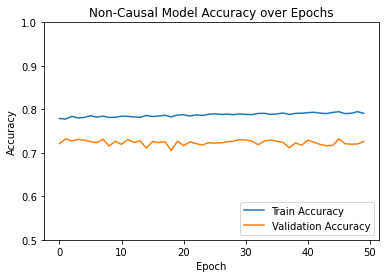

73/73 - 0s - loss: 0.6563 - accuracy: 0.7261 - 91ms/epoch - 1ms/step
Non-Causal Model Test Accuracy: 0.7261
Non-Causal Model Test Loss: 0.6563


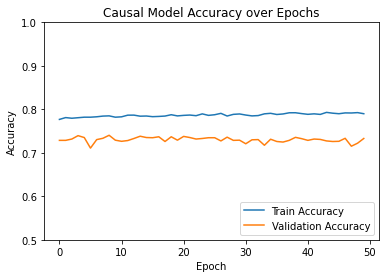

73/73 - 0s - loss: 0.6311 - accuracy: 0.7330 - 80ms/epoch - 1ms/step
Causal Model Test Accuracy: 0.7330
Causal Model Test Loss: 0.6311


In [ ]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential,
    history: Sequential,
    mfcc_test: dict,
    labels_test: dict,
    model_name: str = "Model",
) -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mfcc_test: Testdaten (MFCC)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mfcc_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell (Mit Zukunftsinformation)
plot_accuracy_and_evaluate(
    non_causal_model, history, mfcc_test, labels_test, model_name="Non-Causal Model"
)

# Beispielaufruf für das Causal Modell (Ohne Zukunftsinformation)
plot_accuracy_and_evaluate(
    causal_model,
    causal_history,
    mfcc_test,
    labels_test,
    model_name="Causal Model",
)
